# Learn Pandas with Election Data
## Data use cases demonstration - Part 2
For a lecture on Python tools for data scientists, I prepared few data used cases, to demonstrate pandas,numpy and matplotlib functionality. <br>
In this tutorial, US Election data is used. The data is published by the Federal Election Commission, and can be downloaded here: https://www.fec.gov<br>
The election data website, contain many data sets, with election information. Data about Candidates, Committees, fund raising transactions, contributors information, etc.<br>


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

## Election data ##
### Data is Published by Federal Election Commission, US

In this demonstration, we will explore individuals contributions to candidates at 2017-2018 election cycle.<br>


### Candidate data

Download candidate_summary_2018.csv.  
* https://www.fec.gov/data/advanced/?tab=candidates

In [2]:
df_candidates = pd.read_csv('Form2Filer_2018.csv')
df_candidates.head()

,CANDIDATE_ID,CANDIDATE_NAME,PARTY,PARTY_CODE,CANDIDATE_OFFICE,CANDIDATE_OFFICE_CODE,CANDIDATE_OFFICE_STATE,CANDIDATE_OFFICE_STATE_CODE,CANDIDATE_OFFICE_DISTRICT,CITY,STATE,ZIP,ELECTION_YEAR,RECEIPT_DATE,REPORT_YEAR,BEGIN_IMAGE_NUMBER
0,H8DC00192,"CHEEKS, JOHN C",Independent American Party,IAP,House,H,District Of Columbia,DC,0.0,WASHINGTON,DC,20007.0,2018,18-OCT-18,2018,201810180300238682
1,H8NJ07256,"MOXLEY, DIANE",Green Party,GRE,House,H,New Jersey,NJ,7.0,GARWOOD,NJ,7027.0,2018,17-OCT-18,2018,201810170300237429
2,S8RI00177,"COSTA, MICHAEL",Independent,IND,Senate,S,Rhode Island,RI,0.0,BRISTOL,RI,28099998.0,2018,16-OCT-18,2018,201810169125548990
3,H8PA16094,"BEEMAN, EBERT GORDAN",Libertarian Party,LIB,House,H,Pennsylvania,PA,16.0,ERIE,PA,16510.0,2018,13-OCT-18,2018,201810139124739087
4,H8MD04239,"BISHOP, DAVID ANTHONY DARK HORSE",Libertarian Party,LIB,House,H,Maryland,MD,4.0,ARNOLD,MD,21012.0,2018,12-OCT-18,2018,201810129124516955


### Filter the data features
Lets focus only on 2018 election to the congress. Meaning, we select only the data with the following features.
* ELECTION_YEAR: 2018
* CANDIDATE_OFFICE: House or Senate

In [3]:
print(len(df_candidates))
election_year_2018 = (df_candidates['ELECTION_YEAR'] == 2018 )
congress_candidate = ~(df_candidates['CANDIDATE_OFFICE'] == 'President')
df_candidates = df_candidates[election_year_2018 & congress_candidate]
print(len(df_candidates))

3148
3041


To visualize number of candidates per party, we use pandas  `values_count()` method on `PARTY_CODE` column, and plot it as bar plot.

Text(0.5,1,'Candidates by Party')

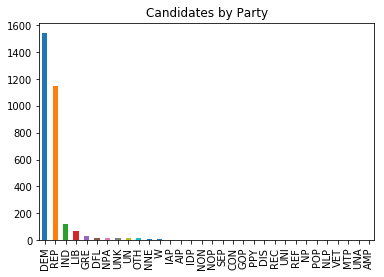

In [4]:
ax = df_candidates.PARTY_CODE.value_counts().plot(kind='bar')#, rot=45)
ax.set_title('Candidates by Party')

Text(0.5,1,'Candidates by Office')

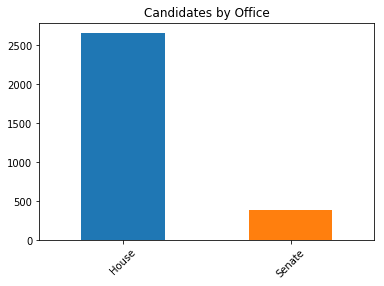

In [5]:
ax = df_candidates.CANDIDATE_OFFICE.value_counts().plot(kind='bar', rot=45)
ax.set_title('Candidates by Office')

#### Manage Missing Party value
To calculatenumber ofmissing values for candidates party, we use `isnull` pandas DataFrame method, and aggregate True values with `sum` function.
* count function will return number elements, True and False.

In [6]:
df_candidates.PARTY_CODE.isnull().sum()*100./df_candidates.PARTY_CODE.count()

0.16469038208168643

Number of candidates missing party values is small, so we will delete them with `drop` pandas function. By default drop function deletes rows by index. To delete columns, add axis=1, in drop parameters.

In [7]:
df_candidates = df_candidates.drop(df_candidates[df_candidates.PARTY.isnull()].index)

Its easier to handle numerical values, so lets create new `Senate` column, with value 1 if candidate office is senate, and 0 otherwise. 

In [8]:
df_candidates['Senate'] = df_candidates['CANDIDATE_OFFICE'].map({'House':0,
                                                               'Senate':1 })

Delete unneeded columns with drop pandas function. We can delete selected column with drop function, or select the required columns.

In [9]:
cols = ['CANDIDATE_ID','CANDIDATE_NAME','PARTY',
        'Senate','STATE']

In [10]:
drop_cols = [c for c in df_candidates.columns if c not in cols]
df_candidates = df_candidates.drop(drop_cols, axis=1)

Lets bin all values of parties with small amount of candidates to one category, `Other`. To do that, we build a list of the relevant parties names, then use `apply` pandas function, to map all other party name values to `Other`.

In [11]:
party_vals = df_candidates.PARTY.value_counts()
big_party_names = [x for x in party_vals.index if party_vals[x]>30]
def map_parties(p):
    if p not in big_party_names:
        return 'Other'
    return p
df_candidates.PARTY = df_candidates.PARTY.apply(map_parties)
df_candidates.head()

,CANDIDATE_ID,CANDIDATE_NAME,PARTY,STATE,Senate
0,H8DC00192,"CHEEKS, JOHN C",Other,DC,0
1,H8NJ07256,"MOXLEY, DIANE",Green Party,NJ,0
2,S8RI00177,"COSTA, MICHAEL",Independent,RI,1
3,H8PA16094,"BEEMAN, EBERT GORDAN",Libertarian Party,PA,0
4,H8MD04239,"BISHOP, DAVID ANTHONY DARK HORSE",Libertarian Party,MD,0


Text(0.5,1,'Candidates by Party')

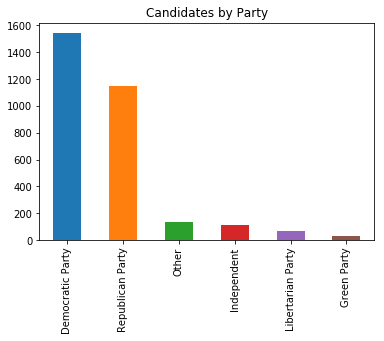

In [12]:
ax = df_candidates.PARTY.value_counts().plot(kind='bar')#, rot=45)
ax.set_title('Candidates by Party')

To plot "transformed" bar plot, we use `barh` plotting function.

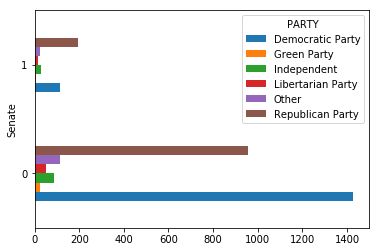

In [13]:
df_candidates.groupby('PARTY').Senate.value_counts().unstack(0).plot.barh()

## Contribution data
We will use the Contributions by individuals data files. <br>
Header for those files, are kept in separate csv file.
Feature description here: https://www.fec.gov/campaign-finance-data/contributions-individuals-file-description/

In [14]:
df_contr_head = pd.read_csv('indiv_header_file.csv')

We will focus on the following fields:

**ENTITY_TP** - type of contributing entity, values are:
- CCM = Candidate Committee
- COM = Committee IND = Individual (a person)
- ORG = Organization (not a committee and not a person)
- PAC = Political Action Committee
- PTY = Party Organization

**TRANSACTION_DT**: Transaction date (MMDDYYYY)

**TRANSACTION_AMT**:	Transaction amount

**OCCUPATION** and **EMPLOYER** - Contributer features.

In [181]:
dateparse = lambda x: pd.datetime.strptime(x, '%m%d%Y')#'%Y-%m-%d %H:%M:%S')

In [123]:
dateparse('01032017')

datetime.datetime(2017, 1, 3, 0, 0)

Data files are big, so for demonstration,we will sample from each file 10% of it and concatenate it into one data frame.
* Files downloaded from https://www.fec.gov/data/advanced/?tab=bulk-data

In [119]:
import os
directory = os.path.join('indiv18', 'by_date')
data_files = os.listdir(directory)

In [137]:
p = 0.01  # 1% of the lines
# if random from [0,1] interval is greater than 0.1 the row will be skipped
file = os.path.join(directory, data_files[0])
df_contr = pd.read_csv(file,
                      delimiter='|', names=df_contr_head.columns,
                      usecols=['OCCUPATION', 'CMTE_ID', 'TRANSACTION_DT',
                               'EMPLOYER','ENTITY_TP', 'TRANSACTION_AMT'],
                      parse_dates=['TRANSACTION_DT'], date_parser=dateparse,
         skiprows=lambda i: i>0 and np.random.random() > p)

In [191]:
type(df_contr.loc[0,'TRANSACTION_DT'])

str

In [138]:
df_contr.head()

,CMTE_ID,ENTITY_TP,EMPLOYER,OCCUPATION,TRANSACTION_DT,TRANSACTION_AMT
0,C00629618,IND,PRINCIPAL,DOUBLE NICKEL ADVISORS,2017-01-03,40
1,C00473249,IND,NaN,RETIRED,2017-01-20,500
2,C00397455,IND,PHARMERICA,CEO,2017-01-20,192
3,C00264689,IND,USPS,LETTER CARRIER,2017-01-18,250
4,C00139659,IND,SELF EMPLOYED,TRAVEL AGENT,2017-01-10,250


Lets list the downloaded data files.

In [139]:
 os.listdir(directory)[1:]

['itcont_2018_20170530_20170822.txt',
 'itcont_2018_20170823_20171030.txt',
 'itcont_2018_20171031_20171225.txt',
 'itcont_2018_20171226_20180421.txt',
 'itcont_2018_20180422_20180705.txt',
 'itcont_2018_20180706_20180927.txt',
 'itcont_2018_20180928_52010302.txt',
 'itcont_2018_invalid_dates.txt']

The last file have invalid date data, so we ignor it.

In [140]:
print('Data number of rows:', len(df_contr))
for x in data_files[1:-1]:
    file = os.path.join(directory, x)
    print('Loading: ', x)
    df = pd.read_csv(file,
                      delimiter='|', names=df_contr_head.columns,
                      usecols=['OCCUPATION', 'CMTE_ID', 'TRANSACTION_DT',
                               'EMPLOYER','ENTITY_TP', 'TRANSACTION_AMT'],
                      parse_dates=['TRANSACTION_DT'], date_parser=dateparse,
         skiprows=lambda i: i>0 and np.random.random() > p)
    df_contr = pd.concat([df_contr,df], axis=0)
    print('Data number of rows:', len(df_contr))

Data number of rows: 19790
Loading:  itcont_2018_20170530_20170822.txt
Data number of rows: 39952
Loading:  itcont_2018_20170823_20171030.txt
Data number of rows: 58817
Loading:  itcont_2018_20171031_20171225.txt
Data number of rows: 78368
Loading:  itcont_2018_20171226_20180421.txt
Data number of rows: 98176
Loading:  itcont_2018_20180422_20180705.txt
Data number of rows: 117998
Loading:  itcont_2018_20180706_20180927.txt
Data number of rows: 137685
Loading:  itcont_2018_20180928_52010302.txt
Data number of rows: 138238


In [143]:
df_contr.to_csv(os.path.join(directory,
                                'sampled_itcont_2018.txt'), index=False)

In [421]:
sam_dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
df_contr = pd.read_csv(os.path.join(directory, 'sampled_itcont_2018.txt'),
                      parse_dates=['TRANSACTION_DT'], date_parser=sam_dateparse)

In [422]:
df_contr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138238 entries, 0 to 138237
Data columns (total 6 columns):
CMTE_ID            138238 non-null object
ENTITY_TP          138193 non-null object
EMPLOYER           123026 non-null object
OCCUPATION         130417 non-null object
TRANSACTION_DT     138238 non-null datetime64[ns]
TRANSACTION_AMT    138238 non-null int64
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 6.3+ MB


In [423]:
df_contr.head()

,CMTE_ID,ENTITY_TP,EMPLOYER,OCCUPATION,TRANSACTION_DT,TRANSACTION_AMT
0,C00629618,IND,PRINCIPAL,DOUBLE NICKEL ADVISORS,2017-01-03,40
1,C00473249,IND,NaN,RETIRED,2017-01-20,500
2,C00397455,IND,PHARMERICA,CEO,2017-01-20,192
3,C00264689,IND,USPS,LETTER CARRIER,2017-01-18,250
4,C00139659,IND,SELF EMPLOYED,TRAVEL AGENT,2017-01-10,250


### Explore contribution type
View number of entries per each category of entity type.

In [424]:
df_contr.ENTITY_TP.value_counts()

IND    137891
ORG       141
CAN       132
PAC        23
CCM         3
COM         2
PTY         1
Name: ENTITY_TP, dtype: int64

We will focus only on on contributions from individuals and organizations.To be sure we are not missing important data,lets visualize contribution amount aggregation by entity type.

Text(0.5,1,'Contribution amount per contribution type')

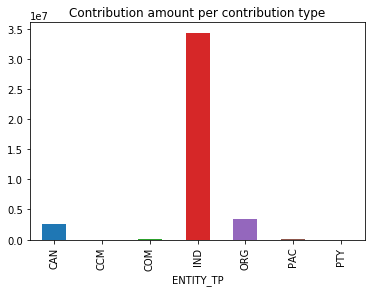

In [425]:
ax = df_contr.groupby('ENTITY_TP')['TRANSACTION_AMT'].sum().plot(kind='bar')#, rot=45)
ax.set_title('Contribution amount per contribution type')

In [426]:
df_contr = df_contr[(df_contr['ENTITY_TP']=='IND') | (df_contr['ENTITY_TP']=='ORG')]

Its easier to handle numeric values, so lets create `ind` column,that will have 1 value,if entity type is IND, and 0 other wise.

In [427]:
df_contr['Ind'] = df_contr.ENTITY_TP.map({'IND':1,'ORG':0})
df_contr = df_contr.drop(['ENTITY_TP'],axis=1)
df_contr.head()

,CMTE_ID,EMPLOYER,OCCUPATION,TRANSACTION_DT,TRANSACTION_AMT,Ind
0,C00629618,PRINCIPAL,DOUBLE NICKEL ADVISORS,2017-01-03,40,1
1,C00473249,NaN,RETIRED,2017-01-20,500,1
2,C00397455,PHARMERICA,CEO,2017-01-20,192,1
3,C00264689,USPS,LETTER CARRIER,2017-01-18,250,1
4,C00139659,SELF EMPLOYED,TRAVEL AGENT,2017-01-10,250,1


#### Explore EMPLOYER and OCCUPATION 
These features have many unique values. To simplify things, and get some results, lets try to analyze who is working, and create new column `work`, that will be 1 if contributor is working and 0 otherwise. 
* If EMPLOYER and OCCUPATION are Null, we set `work` to be zero.
Lets dive into the case when OCCUPATION is Null and  EMPLOYER is not null.


In [428]:
tmp=df_contr[df_contr['OCCUPATION'].isnull() & ~df_contr['EMPLOYER'].isnull()]
tmp['EMPLOYER'].value_counts()[0:15]

NONE                                121
SELF-EMPLOYED                        65
SBC - SOUTH WESTERN BELL             25
RETIRED                              25
BELLSOUTH TELECOMMS                  13
ATT MOBILITY/ CINGULAR               13
SELF EMPLOYED                        11
PACIFIC BELL TEL CO                   9
AMERITECH                             9
NJ STATE EMPLOYEES ADMN CLERICAL      7
VERIZON-BELL ATLANTIC SOUTH MD        4
NOT EMPLOYED                          4
AT&T COMMUNICATIONS                   4
CITIZENS TELECOM, ROCHESTER NY        3
US EPA                                3
Name: EMPLOYER, dtype: int64

We can see that NONE string is used in some rows instead of Null value. Lets change all Null values to NONE string.

In [429]:
df_contr[['OCCUPATION', 'EMPLOYER']] = df_contr[['OCCUPATION', 'EMPLOYER']].fillna('NONE');

Lets view the most common `OCCUPATION` values in this situation.

In [430]:
tmp = df_contr[(df_contr['EMPLOYER']=='NONE') & (df_contr['OCCUPATION'] != 'NONE')]
tmp.OCCUPATION.value_counts()[0:10]

RETIRED                               6094
NOT EMPLOYED                          5908
UNEMPLOYED                            1443
HOMEMAKER                              325
RETIRED PROFESSOR                       56
SELF EMPLOYED                           45
DISABLED                                42
CONDUIT TOTAL LISTED IN AGG. FIELD      39
SELF                                    24
SELF-EMPLOYED                           23
Name: OCCUPATION, dtype: int64

Lets bin few common values together. 
* To identify the self employed contributors, we check id 'SELF' string is a substring of Employer field.
* To  identify the retired contributer, we check if version of retired are a substring of occupation.

In [431]:
def bin_occupation(x):
    
    if ('SELF' in str(x)):
        return 'SELF EMPLOYED'
    if (('RETIRED' in str(x)) or ('REETIRED' in str(x))):
        return 'RETIRED'
    return x
df_contr['OCCUPATION'] = df_contr['OCCUPATION'].apply(bin_occupation)

In [432]:
tmp = df_contr[(df_contr['EMPLOYER']=='NONE') & (df_contr['OCCUPATION'] != 'NONE')]
tmp.OCCUPATION.value_counts()[0:7]

RETIRED                               6342
NOT EMPLOYED                          5908
UNEMPLOYED                            1443
HOMEMAKER                              325
SELF EMPLOYED                          101
DISABLED                                42
CONDUIT TOTAL LISTED IN AGG. FIELD      39
Name: OCCUPATION, dtype: int64

We can see that most contributors with NONE value are self employed or not working. Based on this, we can create our work mapping function. Its not accurate, but cover the common cases.<br>
To apply a function on each row, we use apply data frame method with parameter `axis=1`.


In [433]:
def is_working(x):
    
    if (x['OCCUPATION']=='NONE') and (x['EMPLOYER']=='NONE'):
        return 0
    if (x['EMPLOYER']=='NONE'):
        if (str(x['OCCUPATION']) == 'SELF EMPLOYED'):
            return 1
        else:
            return 0
    return 1
    
df_contr['Work'] = df_contr.apply(is_working, axis=1)

In [434]:
tmp = df_contr[(df_contr['EMPLOYER']=='NONE') & (df_contr['Work']==1)]
tmp.head()

,CMTE_ID,EMPLOYER,OCCUPATION,TRANSACTION_DT,TRANSACTION_AMT,Ind,Work
1302,C00629378,NONE,SELF EMPLOYED,2017-02-07,80,1,1
5032,C00401224,NONE,SELF EMPLOYED,2017-05-20,1,1,1
5033,C00401224,NONE,SELF EMPLOYED,2017-05-20,1,1,1
5046,C00401224,NONE,SELF EMPLOYED,2017-05-27,90,1,1
9511,C00424713,NONE,SELF EMPLOYED,2017-01-06,50,1,1


In [435]:
df_contr = df_contr.drop(['EMPLOYER','OCCUPATION'], axis=1)

### Committee data
Contribution data is organized by committee, so we need to link each committee to the suitable candidate.

In [436]:
df_committee = pd.read_csv('committee_summary_2018.csv',
                           usecols=['CMTE_ID', 'CAND_ID'])

Select only data rows with non null candidate id.

In [437]:
df_committee = df_committee[~df_committee['CAND_ID'].isnull()]

Merge contributor data with committee data to associate each contribution with candidate and party. <br>
* Read more: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html

In [438]:
df_merge = pd.merge(df_contr, df_committee, on='CMTE_ID')
df_merge.head()

,CMTE_ID,TRANSACTION_DT,TRANSACTION_AMT,Ind,Work,CAND_ID
0,C00629618,2017-01-03,40,1,1,H6CA34245
1,C00633024,2017-02-21,500,1,1,H8CA34282
2,C00633024,2017-03-17,500,1,1,H8CA34282
3,C00629691,2017-03-03,250,1,1,H8CA34142
4,C00629691,2017-01-30,250,1,1,H8CA34142


Merge the result with candidate data, to link the contribution to a party. The candidate id feature, has different column names in both data frames, so we need to use `left_on` and `right_on` merge parameters to state those column names.

In [439]:
df_merge = pd.merge(df_merge, df_candidates, left_on='CAND_ID', 
                   right_on='CANDIDATE_ID')
df_merge.head(5)

,CMTE_ID,TRANSACTION_DT,TRANSACTION_AMT,Ind,Work,CAND_ID,CANDIDATE_ID,CANDIDATE_NAME,PARTY,STATE,Senate
0,C00633024,2017-02-21,500,1,1,H8CA34282,H8CA34282,"HOUTEN, TRACY VAN",Democratic Party,CA,0
1,C00633024,2017-03-17,500,1,1,H8CA34282,H8CA34282,"HOUTEN, TRACY VAN",Democratic Party,CA,0
2,C00630061,2017-02-21,250,1,1,H8CA34332,H8CA34332,"FLORES, YOLIE",Democratic Party,CA,0
3,C00629675,2017-01-30,250,1,1,H8CA34118,H8CA34118,"CARRILLO DONO, WENDY MARIA",Democratic Party,CA,0
4,C00629675,2017-02-21,250,1,1,H8CA34118,H8CA34118,"CARRILLO DONO, WENDY MARIA",Democratic Party,CA,0


In [440]:
df_merge['TRANSACTION_DT'].min()

Timestamp('2016-04-28 00:00:00')

In [441]:
min_date = pd.datetime(year=2017,month=3,day=1)
max_date = pd.datetime(year=2018,month=10,day=1)
df_merge=df_merge[(df_merge['TRANSACTION_DT'] >= min_date) & (df_merge['TRANSACTION_DT'] <= max_date)]


In [442]:
df_merge.describe()

,TRANSACTION_AMT,Ind,Work,Senate
count,20773.000000,20773.000000,20773.000000,20773.000000
mean,426.117364,0.998267,0.794685,0.470948
std,875.118409,0.041594,0.403941,0.499167
min,-5400.000000,0.000000,0.000000,0.000000
25%,25.000000,1.000000,1.000000,0.000000
50%,100.000000,1.000000,1.000000,0.000000
75%,500.000000,1.000000,1.000000,1.000000
max,42696.000000,1.000000,1.000000,1.000000


In [443]:
len(df_merge[df_merge.TRANSACTION_AMT>5000])

81

In [444]:
df_merge[df_merge.TRANSACTION_AMT>5000].Work.value_counts()

1    72
0     9
Name: Work, dtype: int64

In [445]:
df_merge[df_merge.TRANSACTION_AMT>5000].head()

,CMTE_ID,TRANSACTION_DT,TRANSACTION_AMT,Ind,Work,CAND_ID,CANDIDATE_ID,CANDIDATE_NAME,PARTY,STATE,Senate
445,C00504704,2018-02-26,5400,1,1,H0ND01026,H0ND01026,"CRAMER, KEVIN MR.",Republican Party,ND,0
446,C00504704,2018-03-28,5400,1,1,H0ND01026,H0ND01026,"CRAMER, KEVIN MR.",Republican Party,ND,0
447,C00504704,2018-04-11,5400,1,1,H0ND01026,H0ND01026,"CRAMER, KEVIN MR.",Republican Party,ND,0
464,C00504704,2018-02-26,5400,1,1,S8ND00120,S8ND00120,"CRAMER, KEVIN",Republican Party,ND,1
465,C00504704,2018-03-28,5400,1,1,S8ND00120,S8ND00120,"CRAMER, KEVIN",Republican Party,ND,1


Lets remove small parties, to visualize data more clearly

In [448]:
df_merge = df_merge[(df_merge.PARTY=='Republican Party') | (df_merge.PARTY=='Democratic Party')]

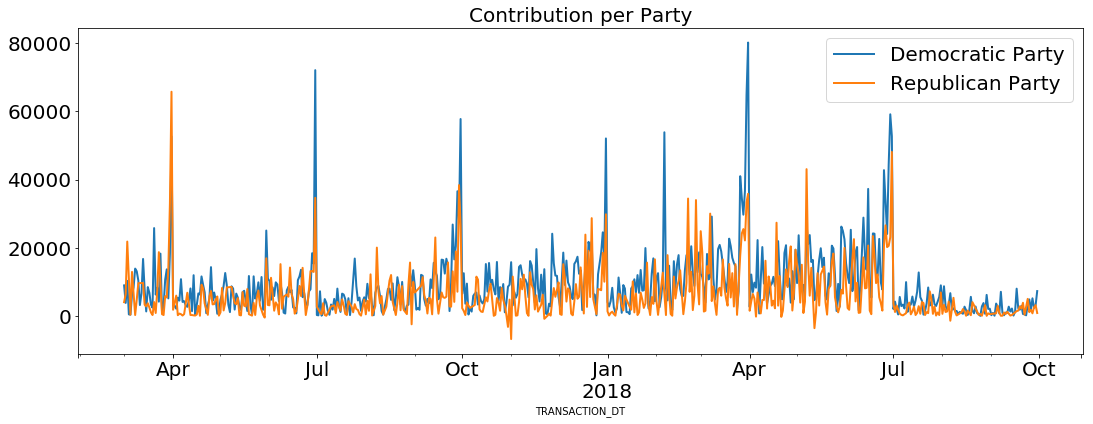

In [463]:
fig = plt.figure(figsize=(18,6))
ax = fig.gca()
for n in df_merge.PARTY.unique():
    df_merge[df_merge['PARTY']==n].groupby('TRANSACTION_DT').TRANSACTION_AMT.sum().plot(linewidth=2, fontsize=20)

ax.set_title('Contribution per Party',fontsize=20)
plt.legend(df_merge.PARTY.unique(), loc='best',fontsize=20)

Lets visualize rolling mean of the transaction amount

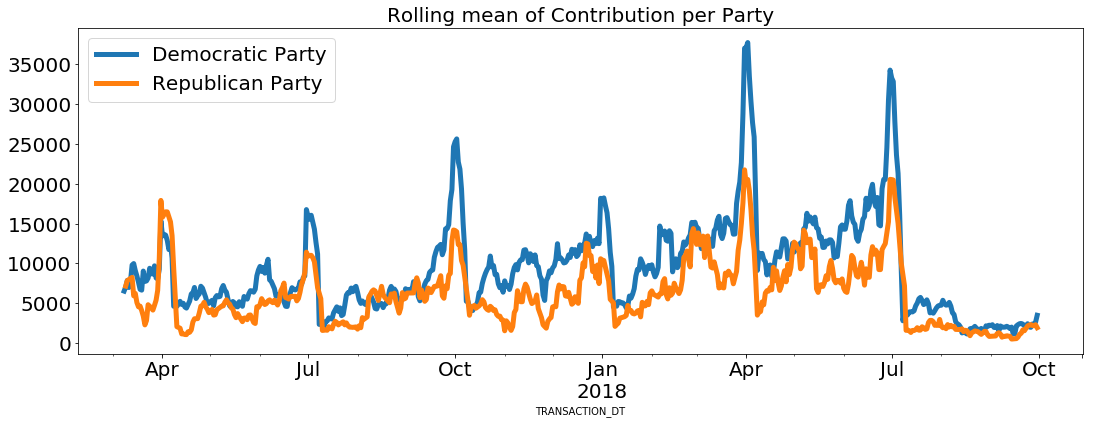

In [451]:
fig = plt.figure(figsize=(18,6))
ax = fig.gca()
for n in df_merge.PARTY.unique():
    df_merge[df_merge['PARTY']==n].groupby('TRANSACTION_DT').TRANSACTION_AMT.sum().rolling(8).mean().plot(linewidth=5, fontsize=20)

ax.set_title('Rolling mean of Contribution per Party',fontsize=20)
plt.legend(df_merge.PARTY.unique(), loc='best',fontsize=20)

We can remove the trend from a time series to investigate seasonality. Pandas can compute and plot the first order difference of the contribution amount.

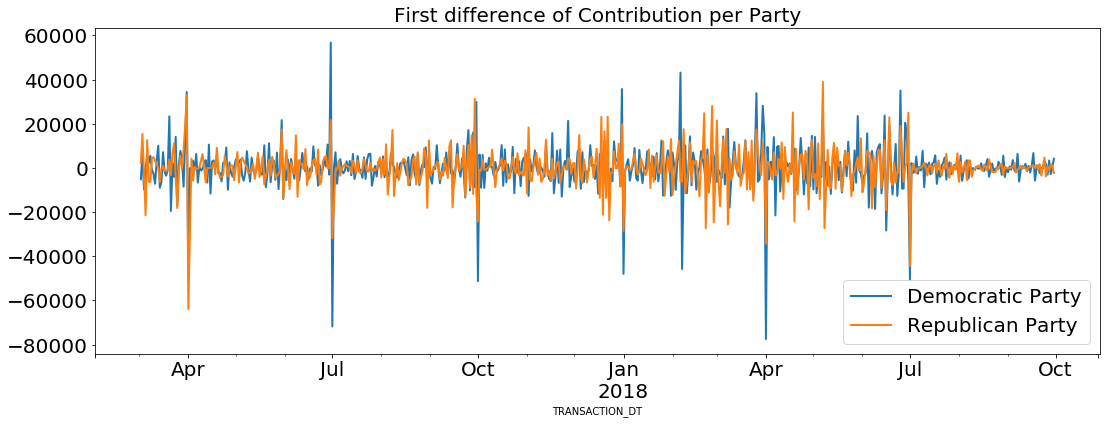

In [465]:
fig = plt.figure(figsize=(18,6))
ax = fig.gca()
for n in df_merge.PARTY.unique():
    df_merge[df_merge['PARTY']==n].groupby('TRANSACTION_DT').TRANSACTION_AMT.sum().diff().plot(linewidth=2, fontsize=20)

ax.set_title('First difference of Contribution per Party',fontsize=20)
plt.legend(df_merge.PARTY.unique(), loc='best',fontsize=20)

Contribution amount, varies a lot. Lets explore the big contributions.

In [466]:
df_big_cont=df_merge[df_merge.TRANSACTION_AMT>7000]


Text(0.5,1,'Number of Contribution bigger then 7000 by State')

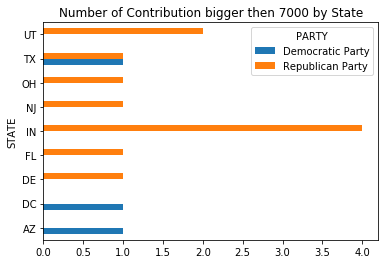

In [467]:
ax = df_big_cont.groupby('PARTY').STATE.value_counts().unstack(0).plot.barh()
ax.set_title('Number of Contribution bigger then 7000 by State')

Text(0.5,1,'Sum of Contribution bigger then 7000 by State')

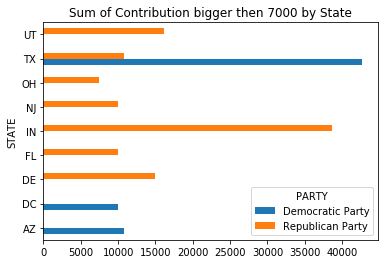

In [454]:
ax = df_big_cont.groupby(['PARTY', 'STATE']).TRANSACTION_AMT.sum().unstack(0).plot.barh()
ax.set_title('Sum of Contribution bigger then 7000 by State')

Lets cut contribution data, only to contribution smaller then 1000

In [455]:
df_cut = df_merge[(df_merge.TRANSACTION_AMT<7000) & (df_merge.TRANSACTION_AMT>0)]
df_cut = df_cut.reset_index()

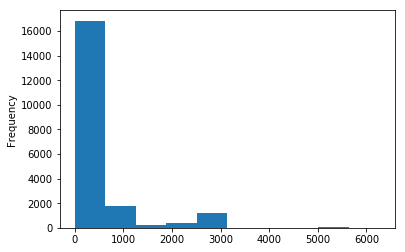

In [456]:
df_cut['TRANSACTION_AMT'].plot(kind='hist')

#### Explore contributions by office

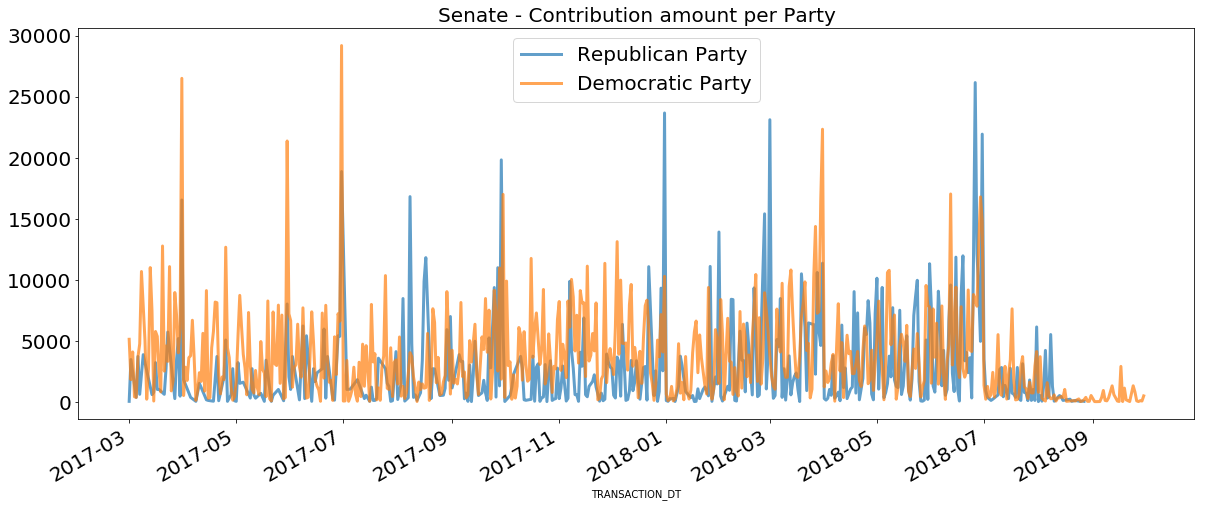

In [457]:
fig = plt.figure(figsize=(20,8))
ax = fig.gca()
df_cut_senate = df_cut[df_cut['Senate']==1]
for n in df_cut_senate.PARTY.unique():
    df_cut_senate[df_cut_senate['PARTY']==n].groupby('TRANSACTION_DT').TRANSACTION_AMT.sum().plot(alpha=0.7,
                                                                                                 fontsize=20,
                                                                                                 linewidth=3)

ax.set_title('Senate - Contribution amount per Party', fontsize=20)
plt.legend(df_cut_senate.PARTY.unique(), loc='best', fontsize=20)

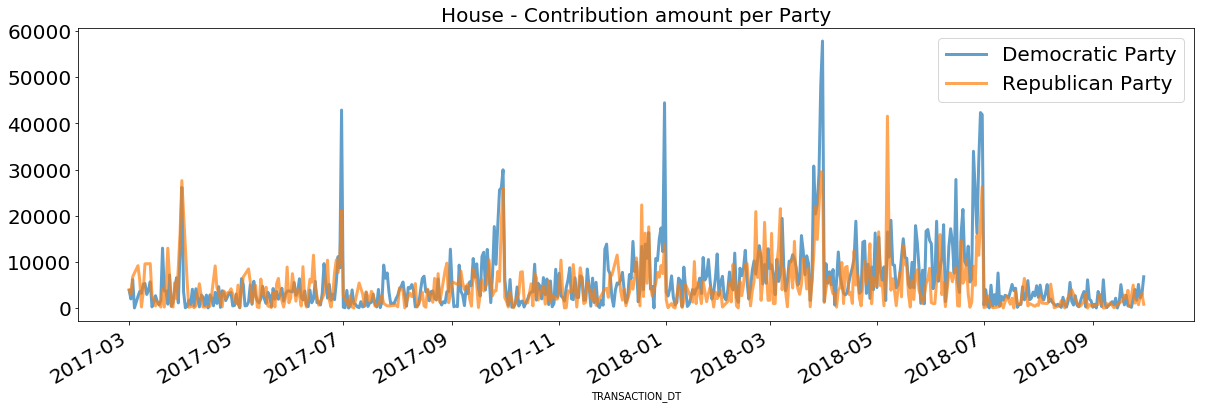

In [458]:
fig = plt.figure(figsize=(20,6))
ax = fig.gca()
df_cut_senate = df_cut[df_cut['Senate']==0]
for n in df_cut_senate.PARTY.unique():
    df_cut_senate[df_cut_senate['PARTY']==n].groupby('TRANSACTION_DT').TRANSACTION_AMT.sum().plot(alpha=0.7,
                                                                                                 fontsize=20,
                                                                                                 linewidth=3)

ax.set_title('House - Contribution amount per Party', fontsize=20)
plt.legend(df_cut_house.PARTY.unique(), loc='best', fontsize=20)

#### Next Steps
Many more aggregation and exploration can be done on this data.<br>
An interesting project will be to download historical contribution data from previous election cycle, and look for features correlated with winning the elections, to try and predict, the current winners in the upcoming election.